In [9]:
import glob, os, torch, torchaudio, random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import warnings

# Ignore specific torchaudio deprecation warnings
warnings.filterwarnings("ignore", message="In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec", category=UserWarning)
warnings.filterwarnings("ignore", message="torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated", category=UserWarning)


DATA_DIR = "/content/drive/MyDrive/recordings"
SAMPLE_RATE = 16000
# Define a fixed length for the spectrograms
FIXED_SPECTROGRAM_LENGTH = 100 # You can adjust this value based on your data

mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE, n_fft=512, win_length=int(0.025*SAMPLE_RATE),
    hop_length=int(0.010*SAMPLE_RATE), n_mels=64, f_min=60, f_max=7600
)
to_db = torchaudio.transforms.AmplitudeToDB()

def load_wav(path):
    wav, sr = torchaudio.load(path)
    if sr != SAMPLE_RATE:
        wav = torchaudio.functional.resample(wav, sr, SAMPLE_RATE)
    wav = torch.clamp(wav / (wav.abs().max() + 1e-9), -1, 1)
    return wav

def augment(spec):
    # SpecAugment-lite
    if random.random()<0.8:
        t = spec.shape[-1]
        # time mask
        tm = random.randint(0, min(10, t//8))
        t0 = random.randint(0, max(0, t-tm))
        spec[:, :, t0:t0+tm] = spec.min()
        # freq mask
        fm = random.randint(0, 8)
        f0 = random.randint(0, max(0, spec.shape[1]-fm))
        spec[:, f0:f0+fm, :] = spec.min()
    return spec

class FSDD(Dataset):
    def __init__(self, root, augment_ok=True):
        self.paths = glob.glob(os.path.join(root, "*.wav"))
        self.augment_ok = augment_ok
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        path = self.paths[i]
        y = int(os.path.basename(path).split("_")[0])
        wav = load_wav(path)
        # optional time shift
        if self.augment_ok and random.random()<0.5:
            shift = int(random.uniform(-0.05, 0.05) * SAMPLE_RATE)
            wav = torch.roll(wav, shifts=shift, dims=-1)
        spec = to_db(mel(wav))  # (1, n_mels, time)

        # Pad or truncate the spectrogram to a fixed length
        current_length = spec.shape[-1]
        if current_length < FIXED_SPECTROGRAM_LENGTH:
            padding = FIXED_SPECTROGRAM_LENGTH - current_length
            spec = torch.nn.functional.pad(spec, (0, padding))
        elif current_length > FIXED_SPECTROGRAM_LENGTH:
            spec = spec[:, :, :FIXED_SPECTROGRAM_LENGTH]

        if self.augment_ok: spec = augment(spec)
        # per-sample norm
        m, s = spec.mean(), spec.std().clamp_min(1e-5)
        spec = (spec - m) / s
        return spec, y

class DWConvBlock(nn.Module):
    def __init__(self, c_in, c_out, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_in, 3, stride=stride, padding=1, groups=c_in, bias=False),
            nn.BatchNorm2d(c_in), nn.ReLU(inplace=True),
            nn.Conv2d(c_in, c_out, 1, bias=False),
            nn.BatchNorm2d(c_out), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class TinyAudioCNN(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),
        )
        self.b1 = DWConvBlock(32, 64, stride=2)
        self.b2 = DWConvBlock(64, 128, stride=2)
        self.b3 = DWConvBlock(128, 128, stride=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Linear(128, n_classes)
    def forward(self, x):
        x = self.stem(x); x = self.b1(x); x = self.b2(x); x = self.b3(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)
        return self.head(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
full = FSDD(DATA_DIR, augment_ok=True)
N = len(full); n_train = int(0.8*N); n_val = N - n_train
train_set, val_set = random_split(full, [n_train, n_val], generator=torch.Generator().manual_seed(42))
val_set.dataset.augment_ok = False

train = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val   = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)

model = TinyAudioCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

best = 0.0
train_acc_list = []
val_acc_list = []
for epoch in range(30):
    model.train()
    train_correct = train_total = 0
    for xb, yb in train:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward(); optimizer.step()
        train_pred = outputs.argmax(1)
        train_correct += (train_pred == yb).sum().item()
        train_total += yb.numel()
    train_acc = train_correct / train_total * 100
    train_acc_list.append(train_acc)


    model.eval(); correct = total = 0
    with torch.no_grad():
        for xb, yb in val:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1)
            correct += (pred==yb).sum().item(); total += yb.numel()
    acc = correct/total*100
    val_acc_list.append(acc)
    scheduler.step()
    if acc>best:
        best=acc
        torch.save(model.state_dict(), "fsdd_tinycnn.pt")
    print(f"epoch {epoch+1}: train acc={train_acc:.4f}%, val acc={acc:.4f}% best={best:.4f}%")

# Export to ONNX for int8/PTQ later
dummy = torch.randn(1,1,64,FIXED_SPECTROGRAM_LENGTH).to(device)
torch.onnx.export(model, dummy, "fsdd_tinycnn.onnx", input_names=["mel"], output_names=["logits"], opset_version=17,dynamo=True)
print("Saved fsdd_tinycnn.pt and fsdd_tinycnn.onnx")

epoch 1: train acc=20.5833%, val acc=26.1667% best=26.1667%
epoch 2: train acc=43.8750%, val acc=50.0000% best=50.0000%
epoch 3: train acc=65.0417%, val acc=73.3333% best=73.3333%
epoch 4: train acc=81.0417%, val acc=82.6667% best=82.6667%
epoch 5: train acc=88.8750%, val acc=89.3333% best=89.3333%
epoch 6: train acc=92.9167%, val acc=93.0000% best=93.0000%
epoch 7: train acc=95.9583%, val acc=93.6667% best=93.6667%
epoch 8: train acc=97.5000%, val acc=95.5000% best=95.5000%
epoch 9: train acc=98.7500%, val acc=95.6667% best=95.6667%
epoch 10: train acc=99.0833%, val acc=96.5000% best=96.5000%
epoch 11: train acc=99.4167%, val acc=96.3333% best=96.5000%
epoch 12: train acc=99.7500%, val acc=97.0000% best=97.0000%
epoch 13: train acc=99.8333%, val acc=96.8333% best=97.0000%
epoch 14: train acc=99.8333%, val acc=97.6667% best=97.6667%
epoch 15: train acc=99.9167%, val acc=97.6667% best=97.6667%
epoch 16: train acc=99.9167%, val acc=97.8333% best=97.8333%
epoch 17: train acc=100.0000%, va

ModuleNotFoundError: No module named 'onnxscript'

In [14]:
torch.onnx.export(model, dummy, "fsdd_tinycnn.onnx", input_names=["mel"], output_names=["logits"], opset_version=1)
print("Saved fsdd_tinycnn.pt and fsdd_tinycnn.onnx")

Saved fsdd_tinycnn.pt and fsdd_tinycnn.onnx


/tmp/ipython-input-4151797882.py:1: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model, dummy, "fsdd_tinycnn.onnx", input_names=["mel"], output_names=["logits"], opset_version=1)
/usr/local/lib/python3.12/dist-packages/torch/onnx/utils.py:753: UserWarning: Setting 'keep_initializers_as_inputs=False' for opset version8 or lower would lead to an invalid ONNX graph. Therefore, 'keep_initializers_as_inputs=False' is ignored during export.Exported

In [11]:
!pip install onnxscript

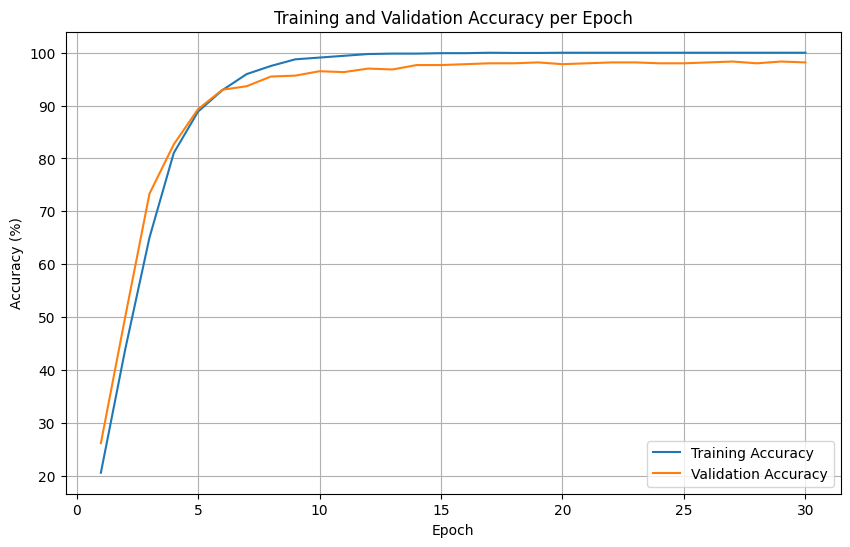

In [12]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc_list) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_list, label='Training Accuracy')
plt.plot(epochs, val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

Integrating model to recognize audio in real time

In [32]:
!pip install sounddevice

In [33]:
!apt-get update
!apt-get install libportaudio2

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,937 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,191 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,271 kB]
Hit:13 https://ppa.launchpadcontent.net/graphics-drive

In [34]:
import sounddevice as sd
import numpy as np
from collections import deque

In [38]:
model = TinyAudioCNN().to(device)  # Instantiate the model
model.load_state_dict(torch.load("fsdd_tinycnn.pt", map_location=device)) # Load the state dictionary
model.eval()

TinyAudioCNN(
  (stem): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (b1): DWConvBlock(
    (net): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (b2): DWConvBlock(
    (net): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 1

In [40]:
#preprocessing
buffer = deque(maxlen=SAMPLE_RATE)

def predic_frame(adio_chunk):
  wav = torch.chunk(torch.Tensor(adio_chunk), 1, dim=0).unsqueeze(0).to(device)
  spec = to_db(mel(wav))
  spec = (spec - spec.mean()) / spec.std().clamp_min(1e-9)
  with torch.no_grad():
      pred = model(spec.unsqueeze(0)).softmax(dim=1).argmax().item()
  return pred

def callback(in_data, out_data, frames, time, status):
    if status: print(status)
    buffer.extend(in_data.flatten().tolist())
    if len(buffer) < SAMPLE_RATE: return
    pred = predic_frame(np.array(buffer))
    buffer.clear()
    print(f"Predicted class: {pred}")

In [42]:
with sd.InputStream(channels=1, callback=callback, samplerate=SAMPLE_RATE):
    while True:
        sd.sleep(1000)

PortAudioError: Error querying device -1